Soft deadline: `30.03.2022 23:59`

In this homework you will understand the fine-tuning procedure and get acquainted with Huggingface Datasets library

In [1]:
# ! pip install datasets
# ! pip install transformers

For our goals we will use [Datasets](https://huggingface.co/docs/datasets/) library and take `yahoo_answers_topics` dataset - the task of this dataset is to divide documents on 10 topic categories. More detiled information can be found on the dataset [page](https://huggingface.co/datasets/viewer/).


In [1]:
from datasets import load_dataset

In [2]:
dataset = load_dataset('yahoo_answers_topics') # the result is a dataset dictionary of train and test splits in this case

Reusing dataset yahoo_answers_topics (C:\Users\gto_n\.cache\huggingface\datasets\yahoo_answers_topics\yahoo_answers_topics\1.0.0\b2712a72fde278f1d6e96cc4f485fd89ed2f79ecb231441e13645b53da021902)


  0%|          | 0/2 [00:00<?, ?it/s]

In [3]:
dataset

DatasetDict({
    train: Dataset({
        features: ['id', 'topic', 'question_title', 'question_content', 'best_answer'],
        num_rows: 1400000
    })
    test: Dataset({
        features: ['id', 'topic', 'question_title', 'question_content', 'best_answer'],
        num_rows: 60000
    })
})

# Fine-tuning the model** (20 points)

In [4]:
# Take the code from here https://huggingface.co/docs/transformers/training#finetune-in-native-pytorch

In [5]:
from transformers import (ElectraTokenizer, ElectraForSequenceClassification,
                          get_scheduler, pipeline, ElectraForMaskedLM, ElectraModel,  TrainingArguments, Trainer)
from transformers import pipeline
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from tqdm.auto import tqdm
from sklearn.metrics import f1_score
from datasets import load_metric

Fine-tuning procedure on the end task consists of adding additional layers on the top of the pre-trained model. The resulting model can be tuned fully (passing gradients through the all model) or partially.

**Task**: 
- load tokenizer and model
- look at the predictions of the model as-is before any fine-tuning


```
- Why don't you ask [MASK]?
- What is [MASK]
- Let's talk about [MASK] physics
```

- convert `best_answer` to the input tokens (supporting function for dataset is provided below) 

```
def tokenize_function(examples):
    return tokenizer(examples["best_answer"], padding="max_length", truncation=True)

tokenized_datasets = dataset.map(tokenize_function, batched=True)
```

- define optimizer, sheduler (optional)
- fine-tune the model (write the training loop), plot the loss changes and measure results in terms of weighted F1 score
- get the masked word prediction (sample sentences above) on the fine-tuned model, why the results as they are and what should be done in order to change that (write down your answer)
- Tune the training hyperparameters (and write down your results).

**Tips**:
- The easiest way to get predictions is to use transformers `pipeline` function 
- Do not forget to set `num_labels` parameter, when initializing the model
- To convert data to batches use `DataLoader`
- Even the `small` version of Electra can be long to train, so you can take data sample (>= 5000 and set seed for reproducibility)
- You may want to try freezing (do not update the pretrained model weights) all the layers exept the ones for classification, in that case use:


```
for param in model.electra.parameters():
      param.requires_grad = False
```


In [6]:
MODEL_NAME = "google/electra-small-generator"
TOKENIZER_NAME = "google/electra-small-generator"

In [7]:
tokenizer = ElectraTokenizer.from_pretrained(TOKENIZER_NAME)

In [8]:
num_topics = 10
model = ElectraForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=num_topics)

Some weights of the model checkpoint at google/electra-small-generator were not used when initializing ElectraForSequenceClassification: ['generator_predictions.LayerNorm.weight', 'generator_predictions.dense.bias', 'generator_predictions.LayerNorm.bias', 'generator_predictions.dense.weight', 'generator_lm_head.weight', 'generator_lm_head.bias']
- This IS expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-small-generator and are newly initializ

In [9]:
pipe = pipeline(
    "fill-mask",
    model = MODEL_NAME,
    tokenizer = TOKENIZER_NAME
)

In [10]:
print(pipe("Why don't you ask [MASK]?"))

[{'score': 0.5343012809753418, 'token': 2033, 'token_str': 'me', 'sequence': "why don't you ask me?"}, {'score': 0.081960029900074, 'token': 3980, 'token_str': 'questions', 'sequence': "why don't you ask questions?"}, {'score': 0.043953459709882736, 'token': 2068, 'token_str': 'them', 'sequence': "why don't you ask them?"}, {'score': 0.040172502398490906, 'token': 2339, 'token_str': 'why', 'sequence': "why don't you ask why?"}, {'score': 0.030024180188775063, 'token': 4426, 'token_str': 'yourself', 'sequence': "why don't you ask yourself?"}]


In [11]:
print(pipe("What is [MASK]"))

[{'score': 0.9262325167655945, 'token': 1029, 'token_str': '?', 'sequence': 'what is?'}, {'score': 0.051567427814006805, 'token': 1012, 'token_str': '.', 'sequence': 'what is.'}, {'score': 0.021510528400540352, 'token': 999, 'token_str': '!', 'sequence': 'what is!'}, {'score': 0.00011964981240453199, 'token': 1011, 'token_str': '-', 'sequence': 'what is -'}, {'score': 0.00010928453411906958, 'token': 1000, 'token_str': '"', 'sequence': 'what is "'}]


In [12]:
print(pipe("Let's talk about [MASK] physics"))

[{'score': 0.2402748167514801, 'token': 8559, 'token_str': 'quantum', 'sequence': "let's talk about quantum physics"}, {'score': 0.21258684992790222, 'token': 9373, 'token_str': 'theoretical', 'sequence': "let's talk about theoretical physics"}, {'score': 0.05639376491308212, 'token': 10811, 'token_str': 'particle', 'sequence': "let's talk about particle physics"}, {'score': 0.03320787847042084, 'token': 2613, 'token_str': 'real', 'sequence': "let's talk about real physics"}, {'score': 0.022627927362918854, 'token': 8045, 'token_str': 'mathematical', 'sequence': "let's talk about mathematical physics"}]


In [13]:
def tokenize_function(examples):
    return tokenizer(examples["best_answer"], padding="max_length", truncation=True)

tokenized_datasets = dataset.map(tokenize_function, batched=True)

Loading cached processed dataset at C:\Users\gto_n\.cache\huggingface\datasets\yahoo_answers_topics\yahoo_answers_topics\1.0.0\b2712a72fde278f1d6e96cc4f485fd89ed2f79ecb231441e13645b53da021902\cache-e499894db125bdb8.arrow
Loading cached processed dataset at C:\Users\gto_n\.cache\huggingface\datasets\yahoo_answers_topics\yahoo_answers_topics\1.0.0\b2712a72fde278f1d6e96cc4f485fd89ed2f79ecb231441e13645b53da021902\cache-350eb3ac1b93492c.arrow


In [14]:
tokenized_datasets

DatasetDict({
    train: Dataset({
        features: ['id', 'topic', 'question_title', 'question_content', 'best_answer', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 1400000
    })
    test: Dataset({
        features: ['id', 'topic', 'question_title', 'question_content', 'best_answer', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 60000
    })
})

In [15]:
tokenized_datasets['train'][0]

{'id': 0,
 'topic': 4,
 'question_title': "why doesn't an optical mouse work on a glass table?",
 'question_content': 'or even on some surfaces?',
 'best_answer': 'Optical mice use an LED and a camera to rapidly capture images of the surface beneath the mouse.  The infomation from the camera is analyzed by a DSP (Digital Signal Processor) and used to detect imperfections in the underlying surface and determine motion. Some materials, such as glass, mirrors or other very shiny, uniform surfaces interfere with the ability of the DSP to accurately analyze the surface beneath the mouse.  \\nSince glass is transparent and very uniform, the mouse is unable to pick up enough imperfections in the underlying surface to determine motion.  Mirrored surfaces are also a problem, since they constantly reflect back the same image, causing the DSP not to recognize motion properly. When the system is unable to see surface changes associated with movement, the mouse will not work properly.',
 'input_ids

In [16]:
print(torch.cuda.get_device_name(0))
torch.cuda.is_available()
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)

NVIDIA GeForce RTX 2070 Super


ElectraForSequenceClassification(
  (electra): ElectraModel(
    (embeddings): ElectraEmbeddings(
      (word_embeddings): Embedding(30522, 128, padding_idx=0)
      (position_embeddings): Embedding(512, 128)
      (token_type_embeddings): Embedding(2, 128)
      (LayerNorm): LayerNorm((128,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (embeddings_project): Linear(in_features=128, out_features=256, bias=True)
    (encoder): ElectraEncoder(
      (layer): ModuleList(
        (0): ElectraLayer(
          (attention): ElectraAttention(
            (self): ElectraSelfAttention(
              (query): Linear(in_features=256, out_features=256, bias=True)
              (key): Linear(in_features=256, out_features=256, bias=True)
              (value): Linear(in_features=256, out_features=256, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): ElectraSelfOutput(
              (dense): Linear(in_

In [17]:
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)

In [18]:
df = tokenized_datasets.remove_columns(['id', 'best_answer', 'question_title', 'question_content'])
df

DatasetDict({
    train: Dataset({
        features: ['topic', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 1400000
    })
    test: Dataset({
        features: ['topic', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 60000
    })
})

In [19]:
df = df.rename_column("topic", "labels")
df

DatasetDict({
    train: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 1400000
    })
    test: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 60000
    })
})

In [20]:
df['train'][0]

{'labels': 4,
 'input_ids': [101,
  9380,
  12328,
  2224,
  2019,
  2419,
  1998,
  1037,
  4950,
  2000,
  5901,
  5425,
  4871,
  1997,
  1996,
  3302,
  4218,
  1996,
  8000,
  1012,
  1996,
  18558,
  28649,
  2013,
  1996,
  4950,
  2003,
  16578,
  2011,
  1037,
  16233,
  2361,
  1006,
  3617,
  4742,
  13151,
  1007,
  1998,
  2109,
  2000,
  11487,
  29238,
  8496,
  1999,
  1996,
  10318,
  3302,
  1998,
  5646,
  4367,
  1012,
  2070,
  4475,
  1010,
  2107,
  2004,
  3221,
  1010,
  13536,
  2030,
  2060,
  2200,
  12538,
  1010,
  6375,
  9972,
  15115,
  2007,
  1996,
  3754,
  1997,
  1996,
  16233,
  2361,
  2000,
  14125,
  17908,
  1996,
  3302,
  4218,
  1996,
  8000,
  1012,
  1032,
  24978,
  2378,
  3401,
  3221,
  2003,
  13338,
  1998,
  2200,
  6375,
  1010,
  1996,
  8000,
  2003,
  4039,
  2000,
  4060,
  2039,
  2438,
  29238,
  8496,
  1999,
  1996,
  10318,
  3302,
  2000,
  5646,
  4367,
  1012,
  22243,
  9972,
  2024,
  2036,
  1037,
  3291,
  1010,
  

In [21]:
df.set_format("torch")
train_df = df['train'].shuffle(seed=42).select(range(5_000))
test_df = df['test'].shuffle(seed=42).select(range(5_000))
train_dl = DataLoader(train_df, shuffle=True, batch_size=16)
test_dl = DataLoader(test_df, batch_size=16)


Loading cached shuffled indices for dataset at C:\Users\gto_n\.cache\huggingface\datasets\yahoo_answers_topics\yahoo_answers_topics\1.0.0\b2712a72fde278f1d6e96cc4f485fd89ed2f79ecb231441e13645b53da021902\cache-b7f7f1bb62f2ff49.arrow
Loading cached shuffled indices for dataset at C:\Users\gto_n\.cache\huggingface\datasets\yahoo_answers_topics\yahoo_answers_topics\1.0.0\b2712a72fde278f1d6e96cc4f485fd89ed2f79ecb231441e13645b53da021902\cache-cce5af71ef792f87.arrow


In [22]:
from transformers import get_scheduler
metric = load_metric("f1")
num_epochs = 5
num_training_steps = num_epochs * len(train_dl)
lr_scheduler = get_scheduler(
    name="linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps
)

In [23]:
torch.cuda.empty_cache()
progress_bar = tqdm(range(num_training_steps))
f1 = []
losses = []
f1s = []
for epoch in range(num_epochs):
    model.train()
    for batch in train_dl:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss
        loss.backward()

        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)
    model.eval()
    for batch in test_dl:
        batch = {k: v.to(device) for k, v in batch.items()}
        with torch.no_grad():
            outputs = model(**batch)

        logits = outputs.logits
        predictions = torch.argmax(logits, dim=-1)
        metric.add_batch(predictions=predictions, references=batch["labels"])
    losses.append((torch.mean(loss).cpu().detach().numpy()))
    f1s.append(metric.compute(average='weighted')['f1'])



  0%|          | 0/1565 [00:00<?, ?it/s]

In [24]:
f1s

[0.4712319820928534,
 0.5443916304156937,
 0.5537650347464874,
 0.5550999849942061,
 0.556869395173584]

In [25]:
losses

[array(1.9476578, dtype=float32),
 array(1.4960648, dtype=float32),
 array(1.2207892, dtype=float32),
 array(1.0172125, dtype=float32),
 array(1.1927514, dtype=float32)]

In [26]:
import matplotlib.pyplot as plt

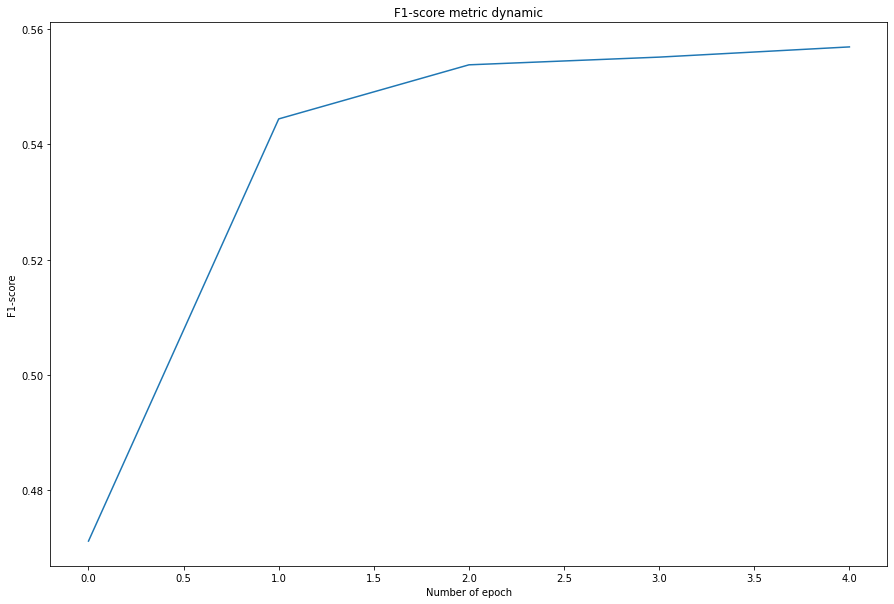

In [27]:
plt.figure(figsize=(15, 10))
plt.plot(f1s)
plt.title('F1-score metric dynamic')
plt.xlabel('Number of epoch')
plt.ylabel('F1-score')
plt.show()

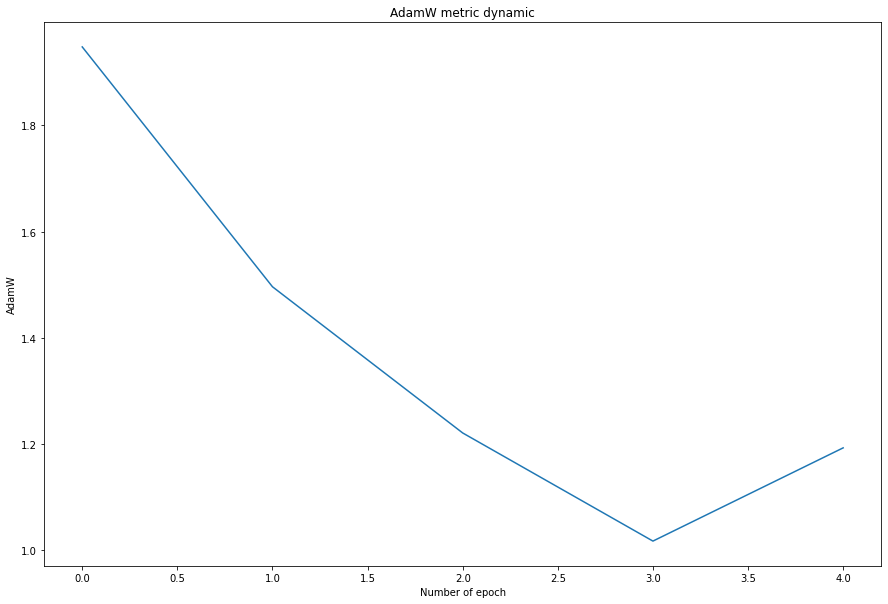

In [28]:
plt.figure(figsize=(15, 10))
plt.plot(losses)
plt.title('AdamW metric dynamic')
plt.xlabel('Number of epoch')
plt.ylabel('AdamW')
plt.show()

# Fit hyperparameters

## The second approach
##  5 bonus points

In [29]:
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer

In [30]:
tokenized_datasets

DatasetDict({
    train: Dataset({
        features: ['id', 'topic', 'question_title', 'question_content', 'best_answer', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 1400000
    })
    test: Dataset({
        features: ['id', 'topic', 'question_title', 'question_content', 'best_answer', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 60000
    })
})

In [31]:
df = tokenized_datasets.remove_columns(['id', 'question_title', 'question_content', 'best_answer'])
df

DatasetDict({
    train: Dataset({
        features: ['topic', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 1400000
    })
    test: Dataset({
        features: ['topic', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 60000
    })
})

In [32]:
df = df.rename_column("topic", "labels")
df

DatasetDict({
    train: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 1400000
    })
    test: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 60000
    })
})

In [33]:
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [34]:
metric = load_metric("f1")
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels, average="weighted")

In [35]:
torch.cuda.empty_cache()
training_args = TrainingArguments(
    output_dir="./results",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=5,
    weight_decay=0.01,
)
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=df["train"].shuffle(seed=42).select(range(5_000)),
    eval_dataset=df["test"].shuffle(seed=42).select(range(1_000)),
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

Loading cached shuffled indices for dataset at C:\Users\gto_n\.cache\huggingface\datasets\yahoo_answers_topics\yahoo_answers_topics\1.0.0\b2712a72fde278f1d6e96cc4f485fd89ed2f79ecb231441e13645b53da021902\cache-634ce62af632433e.arrow
Loading cached shuffled indices for dataset at C:\Users\gto_n\.cache\huggingface\datasets\yahoo_answers_topics\yahoo_answers_topics\1.0.0\b2712a72fde278f1d6e96cc4f485fd89ed2f79ecb231441e13645b53da021902\cache-cd260e0ee220545c.arrow


In [36]:
trainer.train()

C:\Users\gto_n\anaconda3\envs\TrainingPrograms\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 5000
  Num Epochs = 5
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 1565


Step,Training Loss


Saving model checkpoint to ./results\checkpoint-500
Configuration saved in ./results\checkpoint-500\config.json
Model weights saved in ./results\checkpoint-500\pytorch_model.bin
tokenizer config file saved in ./results\checkpoint-500\tokenizer_config.json
Special tokens file saved in ./results\checkpoint-500\special_tokens_map.json
Saving model checkpoint to ./results\checkpoint-1000
Configuration saved in ./results\checkpoint-1000\config.json
Model weights saved in ./results\checkpoint-1000\pytorch_model.bin
tokenizer config file saved in ./results\checkpoint-1000\tokenizer_config.json
Special tokens file saved in ./results\checkpoint-1000\special_tokens_map.json
Saving model checkpoint to ./results\checkpoint-1500
Configuration saved in ./results\checkpoint-1500\config.json
Model weights saved in ./results\checkpoint-1500\pytorch_model.bin
tokenizer config file saved in ./results\checkpoint-1500\tokenizer_config.json
Special tokens file saved in ./results\checkpoint-1500\special_toke

TrainOutput(global_step=1565, training_loss=1.0503250950822434, metrics={'train_runtime': 347.1895, 'train_samples_per_second': 72.007, 'train_steps_per_second': 4.508, 'total_flos': 735648921600000.0, 'train_loss': 1.0503250950822434, 'epoch': 5.0})

In [37]:
import numpy as np
torch.cuda.empty_cache()
trainer.evaluate()

***** Running Evaluation *****
  Num examples = 1000
  Batch size = 16


{'eval_loss': 1.3490136861801147,
 'eval_f1': 0.5738884288512204,
 'eval_runtime': 4.8072,
 'eval_samples_per_second': 208.023,
 'eval_steps_per_second': 13.105,
 'epoch': 5.0}

In [38]:
torch.cuda.empty_cache()
def model_init():
    return model
trainer = Trainer(
    model_init=model_init,
    args=training_args,
    train_dataset=df["train"].shuffle(seed=42).select(range(5_000)),
    eval_dataset=df["test"].shuffle(seed=42).select(range(1_000)),
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)
best_run = trainer.hyperparameter_search(n_trials=2, direction="maximize")

Loading cached shuffled indices for dataset at C:\Users\gto_n\.cache\huggingface\datasets\yahoo_answers_topics\yahoo_answers_topics\1.0.0\b2712a72fde278f1d6e96cc4f485fd89ed2f79ecb231441e13645b53da021902\cache-634ce62af632433e.arrow
Loading cached shuffled indices for dataset at C:\Users\gto_n\.cache\huggingface\datasets\yahoo_answers_topics\yahoo_answers_topics\1.0.0\b2712a72fde278f1d6e96cc4f485fd89ed2f79ecb231441e13645b53da021902\cache-cd260e0ee220545c.arrow
[I 2022-03-30 10:48:33,100] A new study created in memory with name: no-name-280c91c7-896c-43a0-b92a-3421f73c6dff
Trial:
C:\Users\gto_n\anaconda3\envs\TrainingPrograms\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 5000
  Num Epochs = 1
  Instantaneo

Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 1000
  Batch size = 16


[I 2022-03-30 10:49:46,229] Trial 0 finished with value: 0.5853617925668122 and parameters: {'learning_rate': 3.856440009760901e-05, 'num_train_epochs': 1, 'seed': 5, 'per_device_train_batch_size': 16}. Best is trial 0 with value: 0.5853617925668122.
Trial:
C:\Users\gto_n\anaconda3\envs\TrainingPrograms\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 5000
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 625


Step,Training Loss


Saving model checkpoint to ./results\run-1\checkpoint-500
Configuration saved in ./results\run-1\checkpoint-500\config.json
Model weights saved in ./results\run-1\checkpoint-500\pytorch_model.bin
tokenizer config file saved in ./results\run-1\checkpoint-500\tokenizer_config.json
Special tokens file saved in ./results\run-1\checkpoint-500\special_tokens_map.json


Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Evaluation *****
  Num examples = 1000
  Batch size = 16
[I 2022-03-30 10:51:14,182] Trial 1 finished with value: 0.5804763128824436 and parameters: {'learning_rate': 2.6033678814902132e-05, 'num_train_epochs': 1, 'seed': 28, 'per_device_train_batch_size': 8}. Best is trial 0 with value: 0.5853617925668122.


In [39]:
torch.cuda.empty_cache()

In [40]:
trainer.evaluate()

***** Running Evaluation *****
  Num examples = 1000
  Batch size = 16


{'eval_loss': 1.4264410734176636,
 'eval_f1': 0.5804763128824436,
 'eval_runtime': 5.0939,
 'eval_samples_per_second': 196.312,
 'eval_steps_per_second': 12.368,
 'epoch': 1.0}

## After tuning HP
## F1-was: 0.5738884288512204
## F1_tune: 0.5804763128824436
## Improvement on: 1.15%